In [1]:
from pyarrow import fs, schema, string
from pyarrow.dataset import FilenamePartitioning
import pyarrow.dataset as ds
import boto3
import numpy as np
import pandas as pd
from datetime import datetime, timezone
from mats_utils.rawdata.read_data import read_MATS_data
import matplotlib.pylab as plt
import matplotlib.colors as colors
from scipy import optimize
import scipy.interpolate as interp
from scipy.spatial.transform import Rotation as R
import io
from tangentlib import *
from PIL import Image, ImageFilter
from mats_l1_processing.read_parquet_functions import *
from mats_l1_processing.L1_calibration_functions import *
from mats_utils.geolocation.coordinates import *
from skyfield import api as sfapi
import skyfield.sgp4lib as sgp4lib
from skyfield.framelib import itrs
from skyfield.positionlib import Geocentric
# %matplotlib widget


In [2]:
starttime = DT.datetime(2023,2, 13, 0, 30, 0)
endtime = DT.datetime(2023, 2, 13, 12, 45, 0)
df = read_MATS_data(starttime, endtime,filter=None,level='1b',version='0.4')


In [3]:
print('Number of images = ',df.shape[0])
clim=999
plt.close('all')
ccdnames=('IR1','IR4','IR3','IR2','UV1','UV2','NADIR')
flip=(True,False,True,False,True,True,False)
ir1=df[df.CCDSEL==1]
ir2=df[df.CCDSEL==4]
ir3=df[(df.CCDSEL==3)]
ir4=df[(df.CCDSEL==2)]
uv1=df[(df.CCDSEL==5)]
uv2=df[(df.CCDSEL==6)]
for CCDitem in [ir1,ir2,ir3,ir4,uv1,uv2]:
    print (ccdnames[CCDitem.CCDSEL.iloc[0]-1],  CCDitem.shape[0])
ir1.shape

Number of images =  18
IR1 3
IR2 3
IR3 3
IR4 3
UV1 3
UV2 3


(3, 78)

In [4]:
def make_ths(ccditem):
    xpixels = np.linspace(0, ccditem['NCOL'], 5)
    ypixels = np.linspace(0, ccditem['NROW'], 10)
    ths = np.zeros([xpixels.shape[0], ypixels.shape[0]])
    print (ths.shape)
    for i,col in enumerate(xpixels): 
        ths[i,:]=col_heights(ccditem,col,40,spline=True)(ypixels)
    return xpixels,ypixels,ths.T

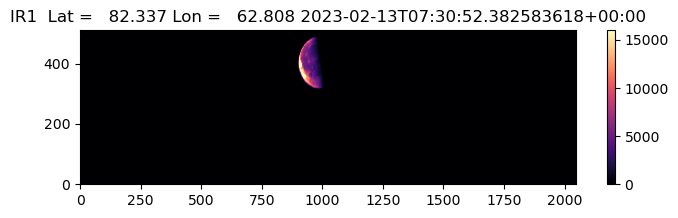

In [5]:

i=0

ch=ir1;clims=[0,16000]
#ch=ir2;clims=[0,1000]
#ch=ir4;clims=[0,60]
#ch=ir3;clims=[0,10]
#ch=uv1;clims=[0,8000]
flip=(True,False,True,False,True,True,False)
fig,axis=plt.subplots(1,1,figsize=[8,2])
try: 
    image=np.stack(ch.ImageCalibrated.iloc[i])
except:
    image = np.float64(Image.open(io.BytesIO(ch.iloc[i].ImageData)))
    if (flip[ch.CCDSEL.iloc[i] - 1]) : image=np.fliplr(image)
sp=plt.imshow(image, cmap="magma", origin="lower", interpolation="none")
axis.axis("auto")
TPlat,TPlon,satalt=satpos(ch.iloc[i])
plt.title("{:4s} Lat = {:8.3f} Lon = {:8.3f} {:s}".format(ccdnames[ch.iloc[i].CCDSEL - 1 ], TPlat, TPlon ,ch.EXPDate.iloc[i].isoformat()))
#CS = axis.contour(*make_ths(ch.iloc[i]), [
#                  50000,  60000, 70000, 80000, 90000, 100000, 110000,200000,250000,300000], colors='w')
#axis.clabel(CS, inline=True)
plt.clim(clims)
plt.colorbar()
plt.show()

In [6]:
def resample_moon (ch):
    def circle(xc,yc,r,f=0):
        cir=[(xc+r*np.cos(th),yc+r*(1-f)*np.sin(th)) for th in np.linspace(0,2*np.pi,100) ]
        return cir
    ts = sfapi.load.timescale()
    planets = sfapi.load('de421.bsp')
    earth = planets['Earth']
    sun = planets['Sun']
    moon= planets['moon']
    ecipos = ch['afsGnssStateJ2000'][0:3]
    d = ch['EXPDate']
    t = ts.from_datetime(d)
    mats = Geocentric(position_au=Distance(m=ch['afsGnssStateJ2000'][0:3]).au, t=t)
    st_vec=(earth+wgs84.subpoint(mats)).at(t).observe(moon).position.km
    centrex = 2047./2
    centrey = 510./2
    xdispersion = 6.06 / 2047  # deg/pix
    ydispersion = 1.52/510  # deg/pix
    q = ch['afsAttitudeState']
    quat = R.from_quat(np.roll(q, -1))
    qprime = ch['qprime']
    qprime = quat * R.from_quat(qprime)  #Rot.from_quat(qprimes[ch])
    x, y = xyz2radec(np.expand_dims(qprime.inv().apply(st_vec), axis=1), deg=True)
    x0 = int(x[0]/xdispersion + centrex)
    y0 = int(-y[0]/ydispersion + centrey)
    print(ch['channel'],x0,y0)
    radius=np.rad2deg(1738.1/norm(st_vec-ecipos/1000))/ydispersion
    print('Radius = ', radius)
    box=120
    try: 
        image=np.stack(ch.ImageCalibrated)
    except:
        image = np.float64(Image.open(io.BytesIO(ch.ImageData)))
        if (flip[ch.CCDSEL.iloc[i] - 1]) : image=np.fliplr(image)
    testimage=image[y0-box:y0+box+1,x0-box:x0+box+1]
    # plt.figure()
    # sp=plt.imshow(testimage, cmap="magma", origin="lower", interpolation="none")
    # axis.axis("auto")
    # cir=np.array(circle (box,box,radius,f=0.0012))
    # plt.plot(cir[:,0],cir[:,1],'r')
    testimage[testimage<1500]=0 #get rid of noisy pixels
    testimage=testimage.astype('int32')
    test=Image.fromarray(testimage,mode='I')
    test = test.convert("L")
    edges = test.filter(ImageFilter.FIND_EDGES)
    ared=np.array(edges)
    # plt.figure()
    # plt.imshow(edges,origin='lower')
    # plt.colorbar()
    def calc_R(xc, yc):
        """ calculate the distance of each 2D points from the center (xc, yc) """
        return np.sqrt((x-xc)**2 + (y-yc)**2)

    def f_2(c):
        """ calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc) """
        Ri = calc_R(*c)
        return Ri - Ri.mean()
    y,x=(ared[:,0:box-20]>10).nonzero()
    x=x+1
    y=y+1 #seems to find the outside of the edge så move one pixel
    center_estimate = box, box
    Ri=calc_R(*center_estimate)
    filter=np.abs(Ri-radius)< 0.2*Ri.mean()
    x=x[filter]
    y=y[filter]
    center_2, ier = optimize.leastsq(f_2, center_estimate)
    #Repeat filtering with better estimated of centre
    y,x=(ared[:,0:box-10]>10).nonzero()
    center_estimate = center_2
    Ri=calc_R(*center_estimate)
    filter=np.abs(Ri-radius)< 0.05*Ri.mean()
    x=x[filter]
    y=y[filter]
    center_2, ier = optimize.leastsq(f_2, center_estimate)
    xc_2, yc_2 = center_2
    xc_new,yc_new=center_2-[box,box]+[x0,y0]
    plt.figure()
    sp=plt.imshow(testimage, cmap="copper", origin="lower", interpolation="none")
    plt.colorbar()
    axis.axis("auto")
    cir2=np.array(circle (xc_2,yc_2,radius,f=0.0012))
    plt.plot(x,y,'.g')
    plt.plot(cir2[:,0],cir2[:,1],'r')
    f = interp.RectBivariateSpline(range(image.shape[0]), range(image.shape[1]), image, kx=2, ky=2)
    new_im = f(yc_new+range(-box,box+1), xc_new+range(-box,box+1))
    plt.figure()
    sp=plt.imshow(new_im, cmap="copper", origin="lower", interpolation="none")
    #plt.pcolor(new_im, cmap="magma")
    axis.axis("auto")
    #plt.clim(clims)
    plt.colorbar()
    cir2=np.array(circle (box,box,radius,f=0.0012))
    #plt.plot(x,y,'.g')
    plt.plot(cir2[:,0],cir2[:,1],'r')
    plt.title("The moon in {} on {} x_pixel = {:4.1f}".format(ch['channel'],ch['EXPDate'].strftime ('%Y-%M-%d %X'),xc_new))
    return new_im,xc_new,yc_new

In [7]:
def resample_moonl1a (ch,xc_new,yc_new):
    import copy
    def circle(xc,yc,r,f=0):
        cir=[(xc+r*np.cos(th),yc+r*(1-f)*np.sin(th)) for th in np.linspace(0,2*np.pi,100) ]
        return cir

    radius=90 #86.3
    print('Radius = ', radius)
    box=120
    image=ch.IMAGE
    #image = np.float64(Image.open(io.BytesIO(ch.ImageData)))
    if (flip[ch.CCDSEL - 1]) : image=np.fliplr(copy.deepcopy(image))
    f = interp.RectBivariateSpline(range(image.shape[0]), range(image.shape[1]), image, kx=2, ky=2)
    new_im = f(yc_new+range(-box,box+1), xc_new+range(-box,box+1))
    plt.figure()
    sp=plt.imshow(new_im, cmap="copper", origin="lower", interpolation="none")
    #plt.pcolor(new_im, cmap="magma")
    axis.axis("auto")
    #plt.clim(clims)
    plt.colorbar()
    cir2=np.array(circle (box,box,radius,f=0.0012))
    #plt.plot(x,y,'.g')
    plt.plot(cir2[:,0],cir2[:,1],'r')
    plt.title("The moon in {} on {} x_pixel = {:4.1f}".format(ch['channel'],ch['EXPDate'].strftime ('%Y-%M-%d %X'),xc_new))
    return new_im,xc_new,yc_new

In [8]:
def resample_mooncal (ch,xc_new,yc_new,img, radius=86.3):
    import copy 
    def circle(xc,yc,r,f=0):
        cir=[(xc+r*np.cos(th),yc+r*(1-f)*np.sin(th)) for th in np.linspace(0,2*np.pi,100) ]
        return cir

    #radius=90#86.3
    print('Radius = ', radius)
    box=120
    flipme=True
    if (img==None) or (img=='IMAGE'):
        image=copy.deepcopy(ch.IMAGE)
    elif img=='cal' or img=='ImageCalibrated':
        image=copy.deepcopy(ch.ImageCalibrated)  
        flipme=False  
    elif img=='image_lsb':
        image=copy.deepcopy(ch.image_lsb)    
    elif img=='':
        image=copy.deepcopy(ch.image_bias_sub) 
    elif img=='':
        image=copy.deepcopy(ch.image_desmeared)
    elif img=='image_dark_sub':
        image=copy.deepcopy(ch.image_dark_sub)
    elif img=='image_calib_nonflipped':
        image=copy.deepcopy(ch.image_calib_nonflipped)
    else:
        raise Exception('image is not set correctly')
    

    #image = np.float64(Image.open(io.BytesIO(ch.ImageData)))
    if flipme:
        if (flip[ch.CCDSEL - 1]) : image=np.fliplr(image)
    f = interp.RectBivariateSpline(range(image.shape[0]), range(image.shape[1]), image, kx=2, ky=2)
    new_im = f(yc_new+range(-box,box+1), xc_new+range(-box,box+1))
    plt.figure()
    sp=plt.imshow(new_im, cmap="copper", origin="lower", interpolation="none")
    #plt.pcolor(new_im, cmap="magma")
    axis.axis("auto")
    #plt.clim(clims)
    plt.colorbar()
    cir2=np.array(circle (box,box,radius,f=0.0012))
    #plt.plot(x,y,'.g')
    plt.plot(cir2[:,0],cir2[:,1],'r')
    plt.title("The moon in {} on {} x_pixel = {:4.1f}".format(ch['channel'],ch['EXPDate'].strftime ('%Y-%M-%d %X'),xc_new))
    return new_im,xc_new,yc_new

In [9]:
def resample_moon_image (ch,xc_new,yc_new, image):
    def circle(xc,yc,r,f=0):
        cir=[(xc+r*np.cos(th),yc+r*(1-f)*np.sin(th)) for th in np.linspace(0,2*np.pi,100) ]
        return cir

    radius=90#86.3
    print('Radius = ', radius)
    box=120

    f = interp.RectBivariateSpline(range(image.shape[0]), range(image.shape[1]), image, kx=2, ky=2)
    new_im = f(yc_new+range(-box,box+1), xc_new+range(-box,box+1))
    plt.figure()
    sp=plt.imshow(new_im, cmap="copper", origin="lower", interpolation="none")
    #plt.pcolor(new_im, cmap="magma")
    axis.axis("auto")
    #plt.clim(clims)
    plt.colorbar()
    cir2=np.array(circle (box,box,radius,f=0.0012))
    #plt.plot(x,y,'.g')
    plt.plot(cir2[:,0],cir2[:,1],'r')
    plt.title("The moon in {} on {} x_pixel = {:4.1f}".format(ch['channel'],ch['EXPDate'].strftime ('%Y-%M-%d %X'),xc_new))
    return new_im,xc_new,yc_new

IR1
(78,)
IR1 981 400
Radius =  86.47691997711755
(78,)
IR1 709 328
Radius =  86.5561049292957
(78,)
IR1 439 277
Radius =  86.63752238631139
IR3
(78,)
IR3 848 413
Radius =  86.68962591195233
(78,)
IR3 577 341
Radius =  86.7691493279313
(78,)
IR3 304 292
Radius =  86.85087700461197
IR4
(78,)
IR4 895 347
Radius =  86.61805475083472
(78,)
IR4 624 273
Radius =  86.69744102185308
(78,)
IR4 353 222
Radius =  86.77911417938711
UV1
(78,)
UV1 805 352
Radius =  86.76182592410244
(78,)
UV1 532 286
Radius =  86.84145876016379


/var/folders/sy/16g461815hq0gp3psxxf04kc0000gn/T/ipykernel_5101/2115941833.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


(78,)
UV1 259 242
Radius =  86.9232986391086


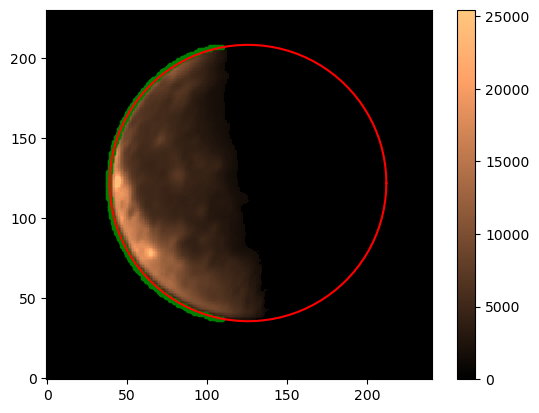

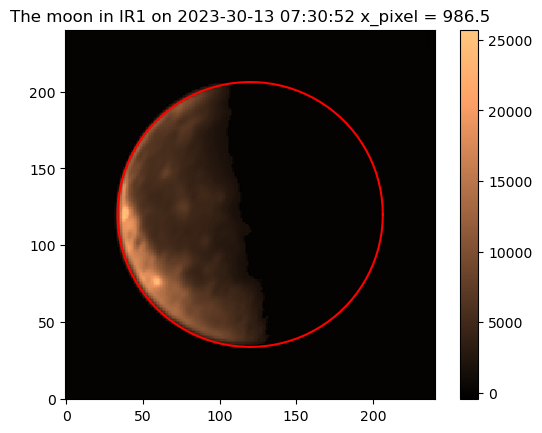

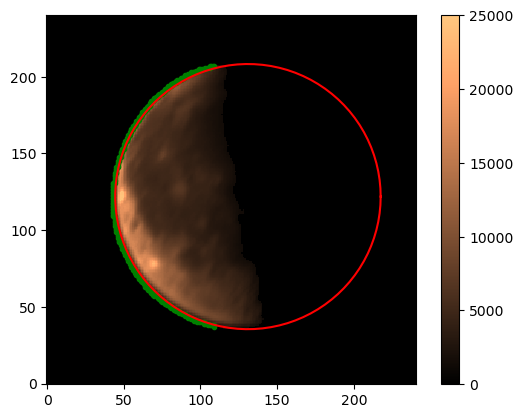

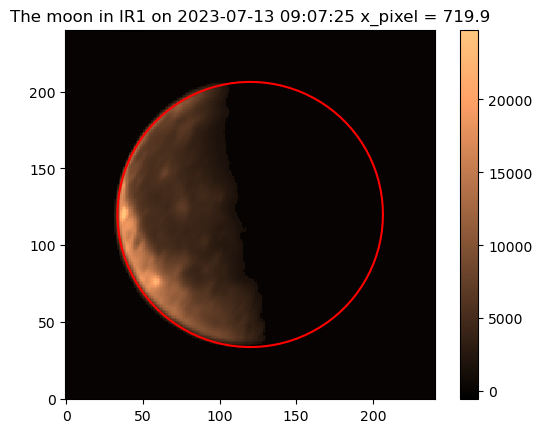

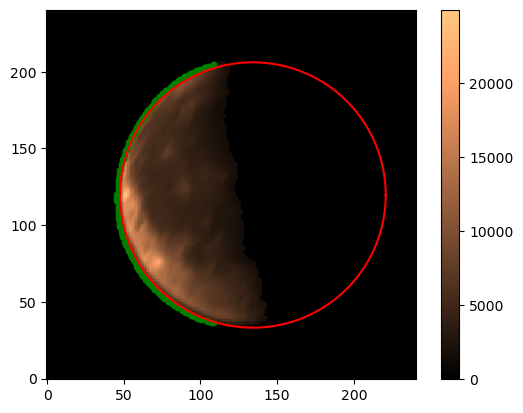

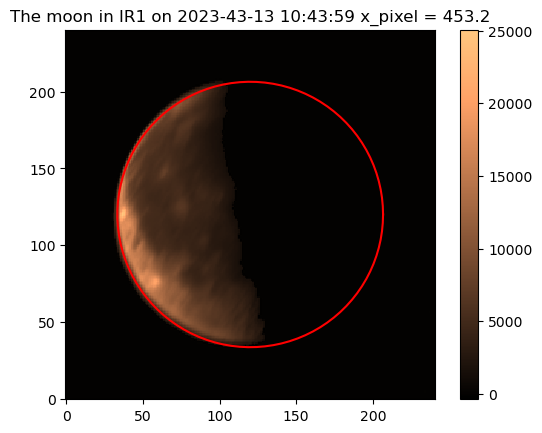

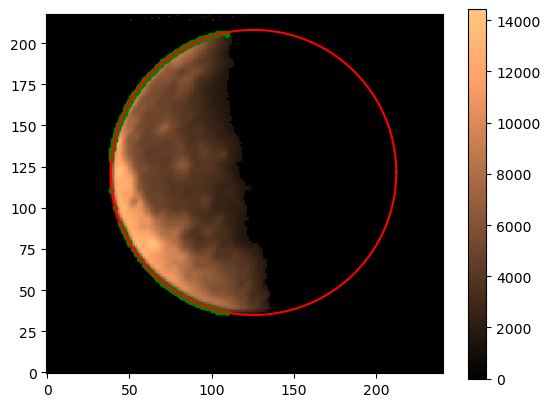

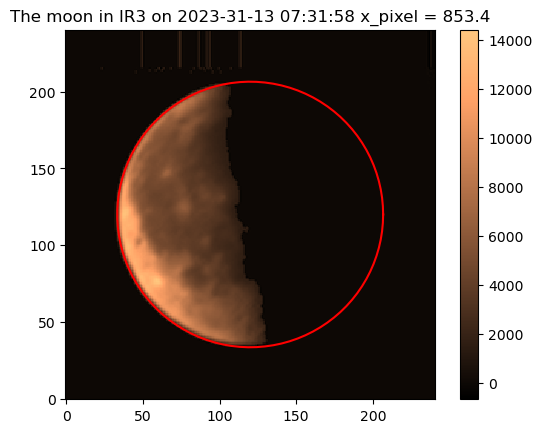

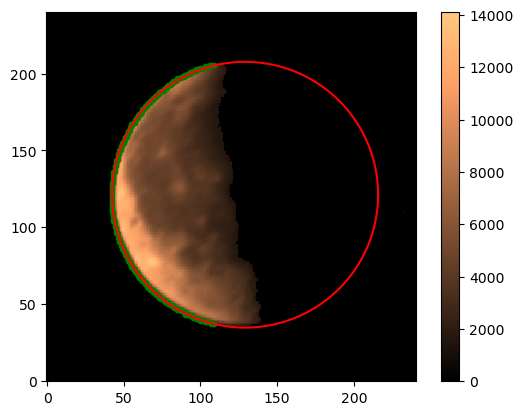

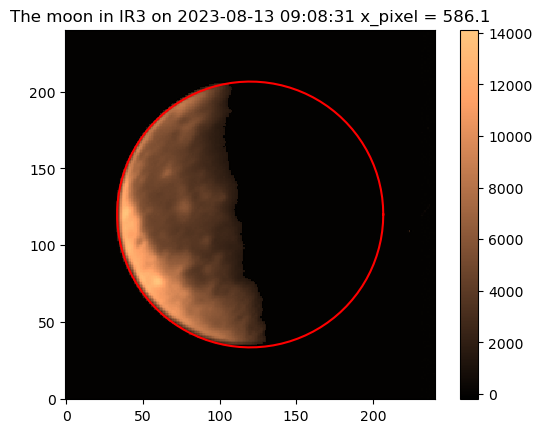

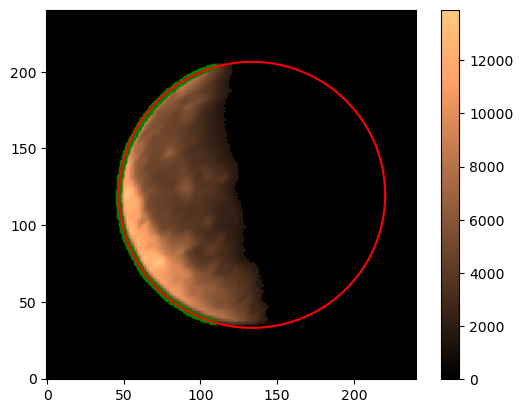

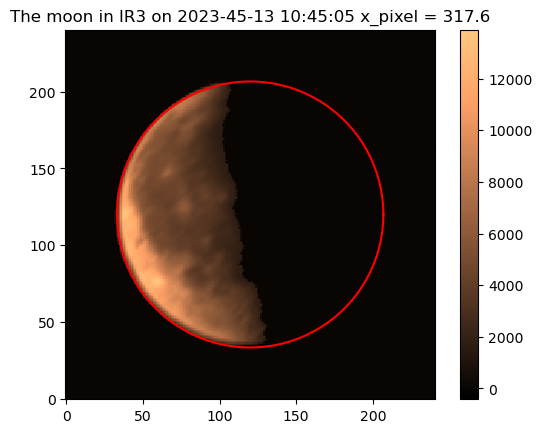

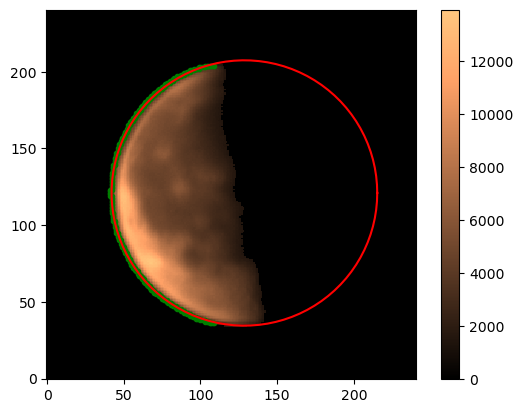

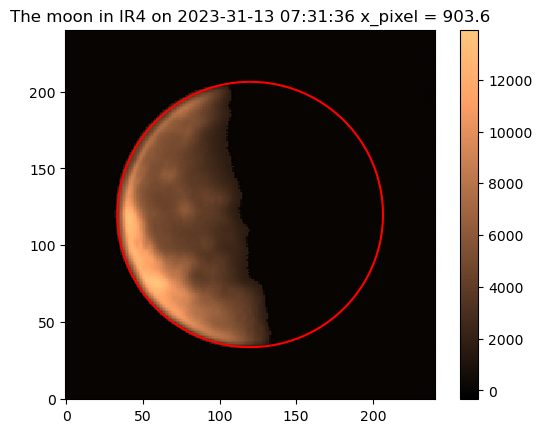

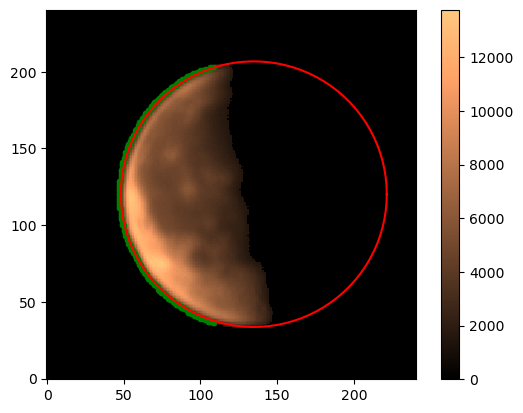

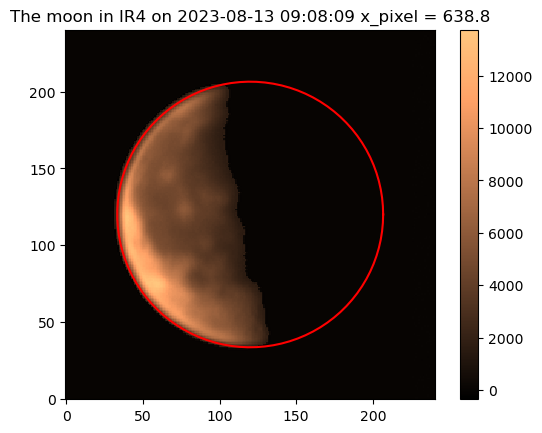

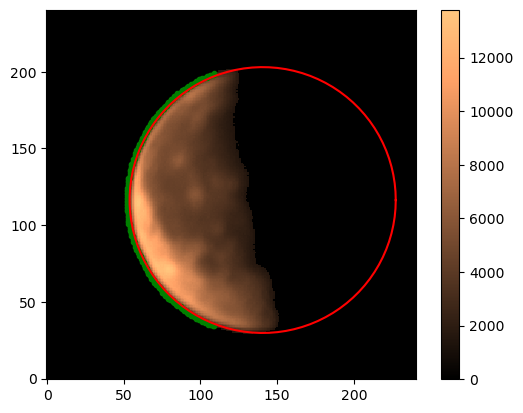

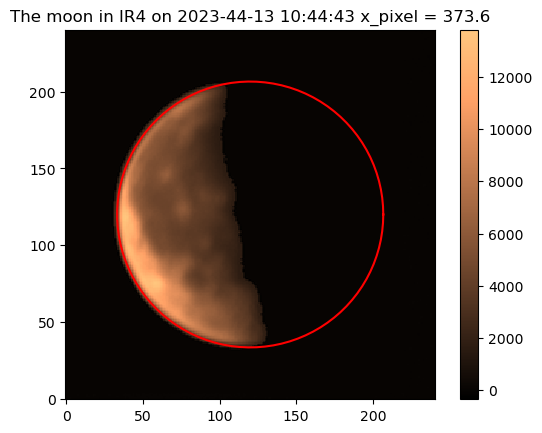

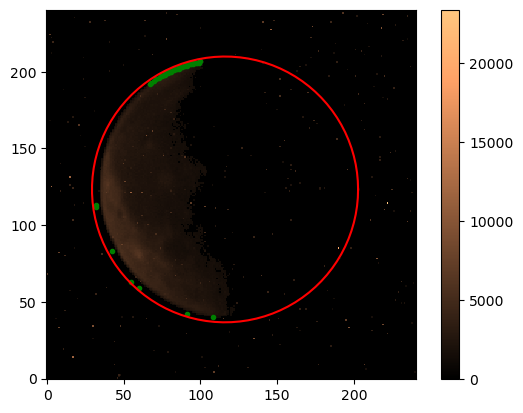

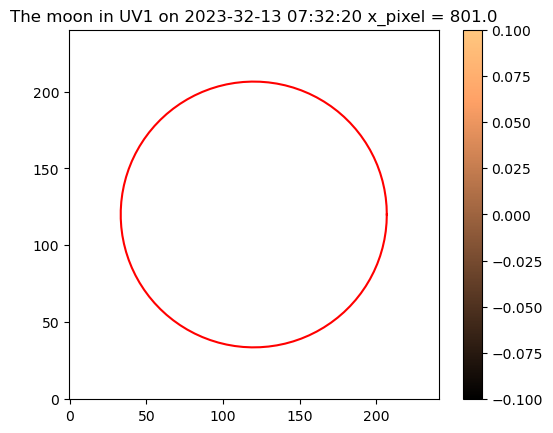

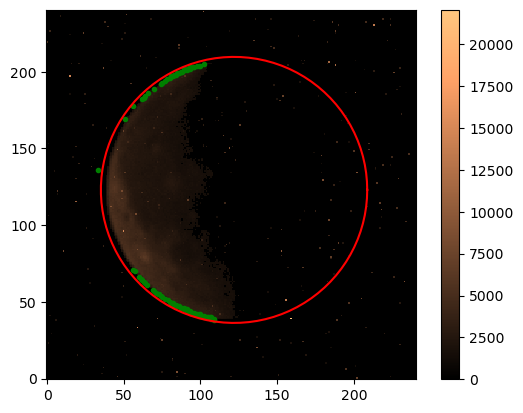

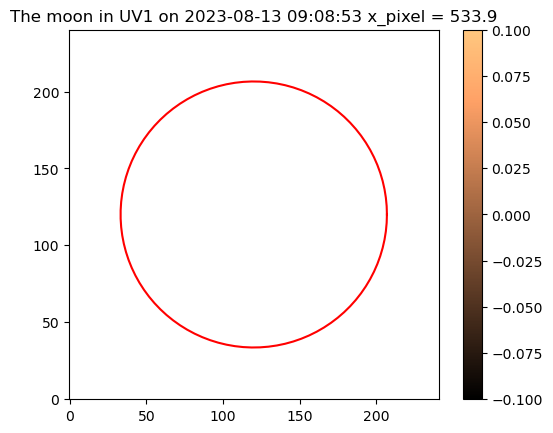

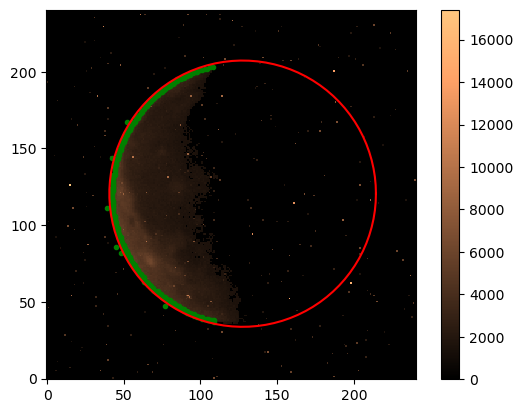

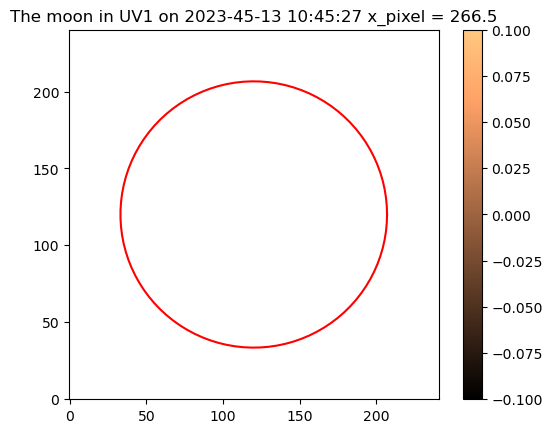

In [10]:
moons={}
channels=[ir1,ir3,ir4,uv1]#,uv2]
for ch in channels:
    label=ch['channel'].iloc[0]
    print(label)
    moons[label]=[]
    #print(moons)
    for i in range(3):
        print(ch.iloc[i].shape)
        res=resample_moon(ch.iloc[i])
        moons[label].append(res)

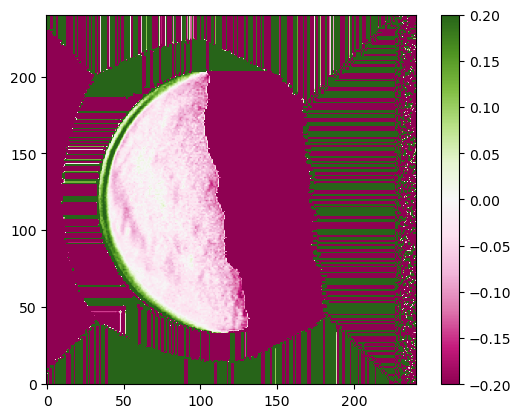

In [11]:
plt.figure()
plt.imshow((moons['IR4'][1][0]-moons['IR4'][0][0])/moons['IR4'][0][0],origin='lower',cmap="PiYG")#,norm=colors.CenteredNorm())
plt.clim([0-0.2, 0+0.2])
#plt.clim([-200,200])
plt.colorbar()

Text(0, 0.5, 'sum of intensity')

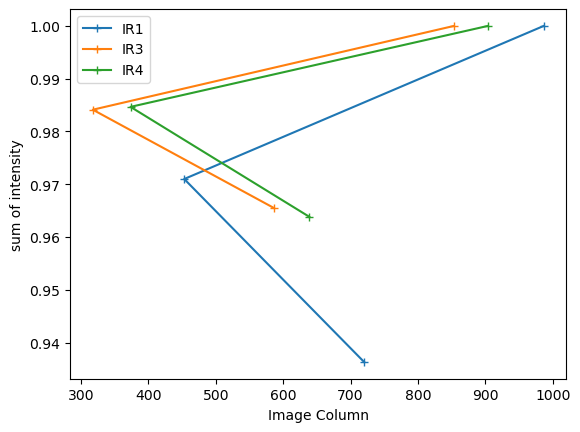

In [12]:
box=120
radius=90#86.61805475083472
xs,ys=np.meshgrid(np.arange(2*box+1)-box,np.arange(2*box+1)-box,sparse=True)
filter=(xs**2+ys**2)<radius**2
plt.figure()
names=['IR1','IR3','IR4']
for ch in names:
    sumref= [moons[ch][0][0][filter].sum() for i in range(3)]
    xval= [moons[ch][i][1] for i in (0,2,1)]
    sums= [moons[ch][i][0][filter].sum()/sumref[i] for i in range(3)]
    plt.plot(xval,sums,'-+')
plt.legend(names)
plt.xlabel('Image Column')
plt.ylabel('sum of intensity')

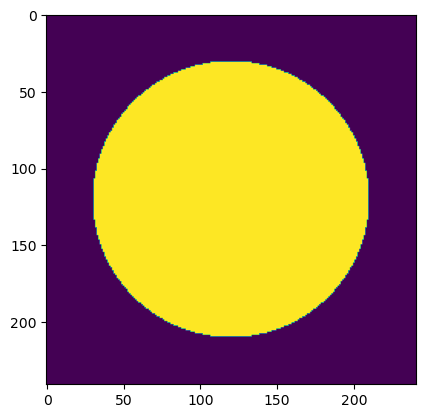

In [13]:
plt.figure()
plt.imshow(filter)

In [14]:
dfl1a = read_MATS_data(starttime, endtime,filter=None,level='1a',version='0.5')

In [15]:
print('Number of images = ',dfl1a.shape[0])
clim=999
plt.close('all')
ccdnames=('IR1','IR4','IR3','IR2','UV1','UV2','NADIR')
flip=(True,False,True,False,True,True,False)
ir1l1a=dfl1a[dfl1a.CCDSEL==1]
ir2l1a=dfl1a[dfl1a.CCDSEL==4]
ir3l1a=dfl1a[(dfl1a.CCDSEL==3)]
ir4l1a=dfl1a[(dfl1a.CCDSEL==2)]
uv1l1a=dfl1a[(dfl1a.CCDSEL==5)]
uv2l1a=dfl1a[(dfl1a.CCDSEL==6)]
for ch in [ir1l1a,ir2l1a,ir3l1a,ir4l1a,uv1l1a,uv2l1a]:
    print (ccdnames[ch.CCDSEL.iloc[0]-1],  ch.shape[0])
ir1l1a.shape

Number of images =  18
IR1 3
IR2 3
IR3 3
IR4 3
UV1 3
UV2 3


(3, 80)

IR1l1a
(80,)
Radius =  90
986.5051463571978   402.1594014687101
(80,)
Radius =  90
719.939762514759   329.875259227557
(80,)
Radius =  90
453.17576059483736   276.66770052428745
IR3l1a
(80,)
Radius =  90
853.3619733523869   414.4660061983654
(80,)
Radius =  90
586.0816203936203   342.14356687733346
(80,)
Radius =  90
317.5889111544709   291.745998373673
IR4l1a
(80,)
Radius =  90
903.6410721335625   347.978242900081
(80,)
Radius =  90
638.7849616203135   273.1952805554556
(80,)
Radius =  90
373.55092050033636   218.37045388404212
UV1l1a
(80,)
Radius =  90
801.0150290536031   355.2976564871389
(80,)
Radius =  90
533.8883380313379   288.9788079498443
(80,)
Radius =  90
266.4953754276246   242.51959137233587


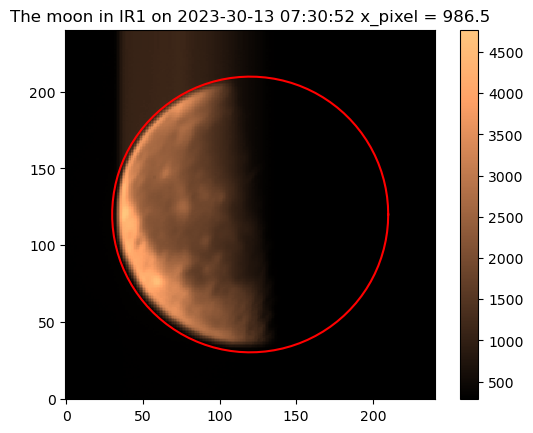

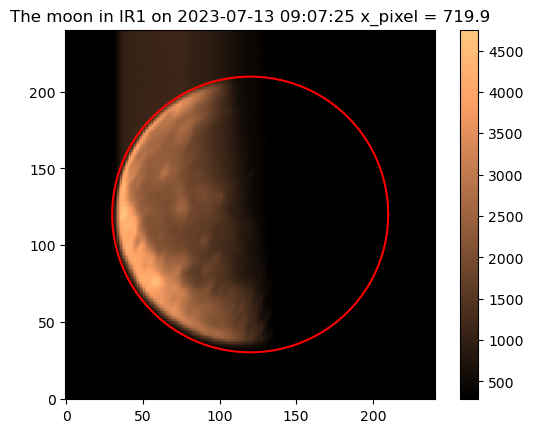

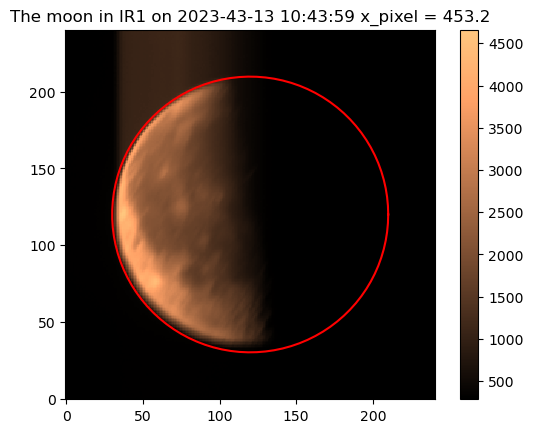

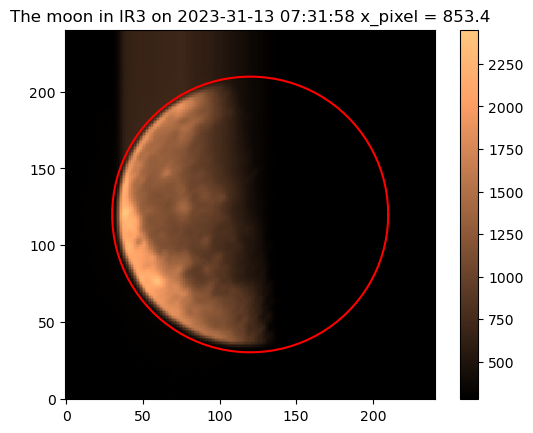

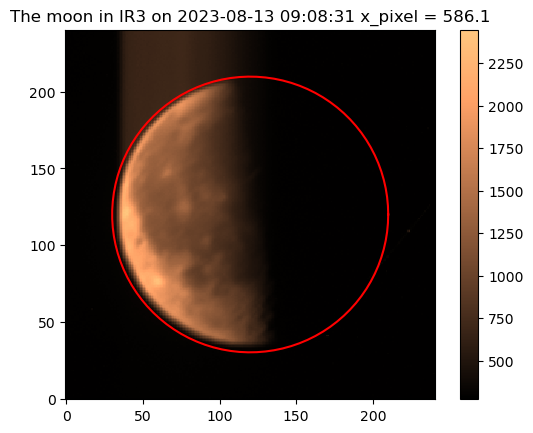

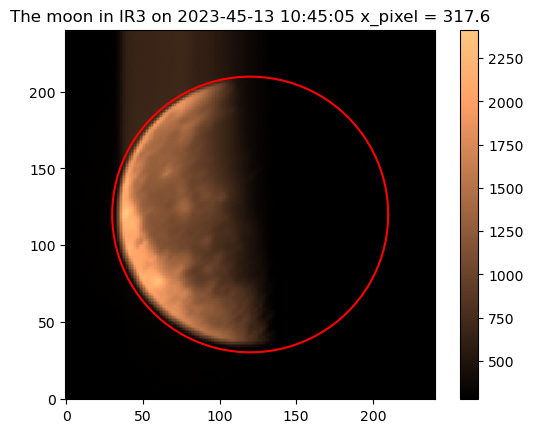

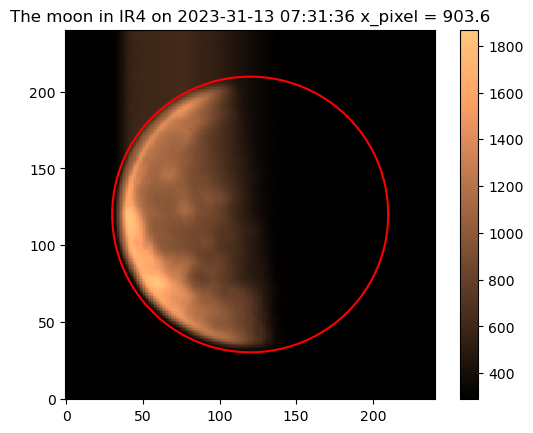

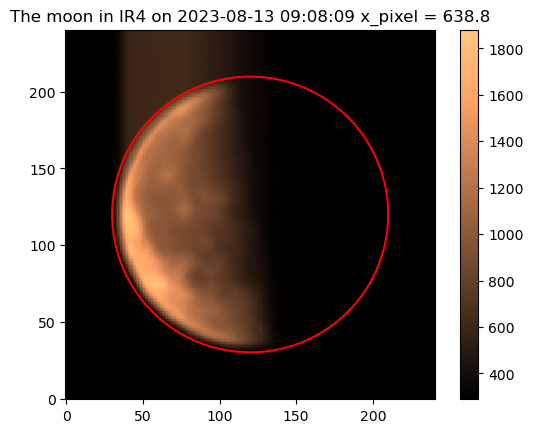

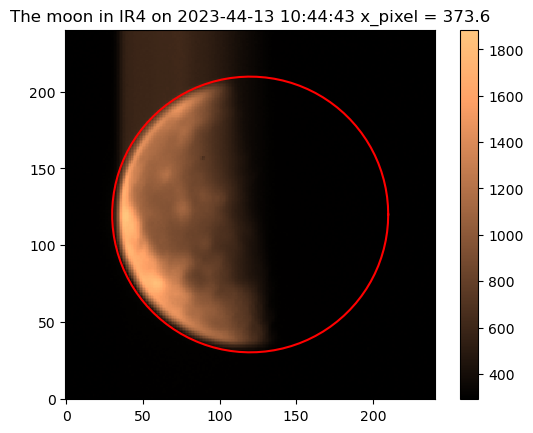

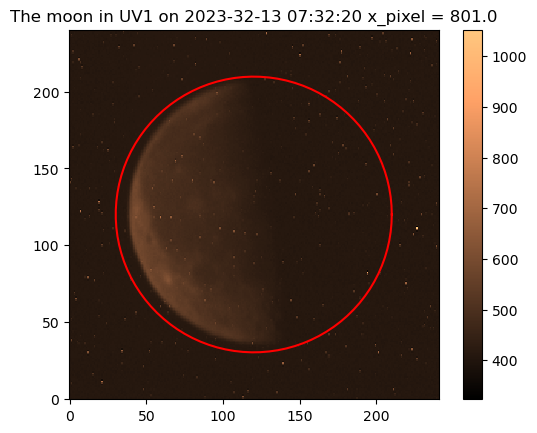

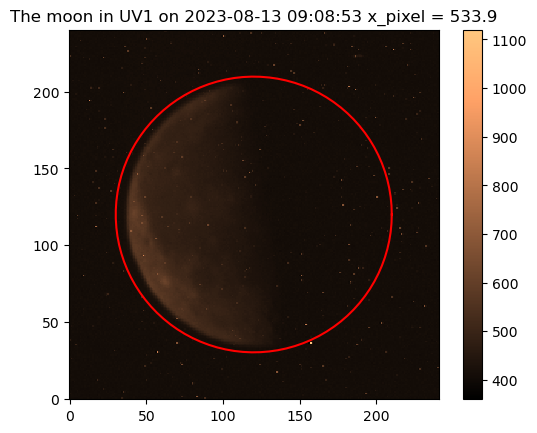

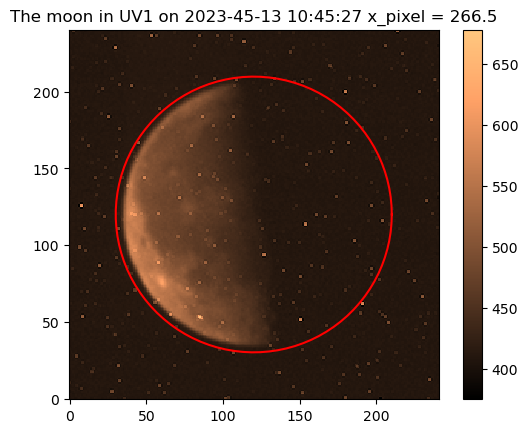

In [16]:

channels=[ir1l1a,ir3l1a,ir4l1a,uv1l1a]#,uv2l1a]
for ch in channels:
    oldlabel=ch['channel'].iloc[0]
    label=ch['channel'].iloc[0]+'l1a'
    print(label)
    moons[label]=[]
    #print(moons)
    for i in range(3):
        print(ch.iloc[i].shape)
        res=resample_moonl1a(ch.iloc[i],moons[oldlabel][i][1],moons[oldlabel][i][2])
        moons[label].append(res)
        print(moons[oldlabel][i][1],' ', moons[oldlabel][i][2])




Text(0, 0.5, 'sum of intensity')

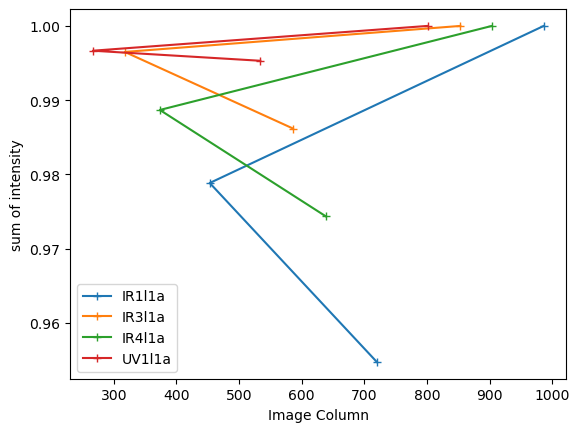

In [17]:
box=120
radius=90#86.61805475083472
xs,ys=np.meshgrid(np.arange(2*box+1)-box,np.arange(2*box+1)-box,sparse=True)
filter=(xs**2+ys**2)<radius**2
plt.figure()
names=['IR1l1a','IR3l1a','IR4l1a','UV1l1a']

for ch in names:
    sumref= [moons[ch][0][0][filter].sum() for i in range(3)]
    xval= [moons[ch][i][1] for i in (0,2,1)]
    sums= [moons[ch][i][0][filter].sum()/sumref[i] for i in range(3)]
    plt.plot(xval,sums,'-+')
plt.legend(names)
plt.xlabel('Image Column')
plt.ylabel('sum of intensity')

In [18]:
from mats_l1_processing.instrument import Instrument
from mats_l1_processing.read_parquet_functions import dataframe_to_ccd_items
from mats_utils.rawdata.calibration import  calibrate_dataframe
from mats_l1_processing.L1_calibrate import L1_calibrate



calibration_file='/Users/lindamegner/MATS/MATS-retrieval/MATS-L1-processing/scripts/calibration_data_linda.toml'
instrument=Instrument(calibration_file)

ir1l1a_cal=calibrate_dataframe(ir1l1a, instrument)
ir2l1a_cal=calibrate_dataframe(ir2l1a, instrument)
ir3l1a_cal=calibrate_dataframe(ir3l1a, instrument)
ir4l1a_cal=calibrate_dataframe(ir4l1a, instrument)
uv1l1a_cal=calibrate_dataframe(uv1l1a, instrument)


    

KeyError: 'default_temp'

In [ ]:
print('*****************************')
print(ir1l1a_cal.columns.tolist)

*****************************
<bound method IndexOpsMixin.tolist of Index(['TMHeaderTime', 'EXPDate', 'OriginFile', 'ProcessingTime', 'RamsesTime',
       'QualityIndicator', 'LossFlag', 'VCFrameCounter', 'SPSequenceCount',
       'TMHeaderNanoseconds', 'SID', 'RID', 'CCDSEL', 'EXPNanoseconds',
       'WDWMode', 'WDWInputDataWindow', 'WDWOV', 'JPEGQ', 'FRAME', 'NROW',
       'NRBIN', 'NRSKIP', 'NCOL', 'NCBINFPGAColumns', 'NCBINCCDColumns',
       'NCSKIP', 'NFLUSH', 'TEXPMS', 'GAINMode', 'GAINTiming',
       'GAINTruncation', 'TEMP', 'FBINOV', 'LBLNK', 'TBLNK', 'ZERO', 'TIMING1',
       'TIMING2', 'VERSION', 'TIMING3', 'NBC', 'BadColumns', 'ImageName',
       'afsAttitudeState', 'afsGnssStateJ2000', 'afsTPLongLatGeod',
       'afsTangentH_wgs84', 'afsTangentPointECI', 'satlat', 'satlon',
       'satheight', 'TPlat', 'TPlon', 'TPheight', 'nadir_sza', 'TPsza',
       'TPssa', 'TPlocaltime', 'HTR1A', 'HTR1B', 'HTR1OD', 'HTR2A', 'HTR2B',
       'HTR2OD', 'HTR7A', 'HTR7B', 'HTR7OD', 'HTR8A'

IR1_image_calib_nonflipped
(83,)
Radius =  100
IR1_image_calib_nonflipped
(83,)
Radius =  100
IR1_image_calib_nonflipped
(83,)
Radius =  100
IR1_image_calib_nonflipped
IR3_image_calib_nonflipped
(83,)
Radius =  100
IR3_image_calib_nonflipped
(83,)
Radius =  100
IR3_image_calib_nonflipped
(83,)
Radius =  100
IR3_image_calib_nonflipped
IR4_image_calib_nonflipped
(83,)
Radius =  100
IR4_image_calib_nonflipped
(83,)
Radius =  100
IR4_image_calib_nonflipped
(83,)
Radius =  100
IR4_image_calib_nonflipped


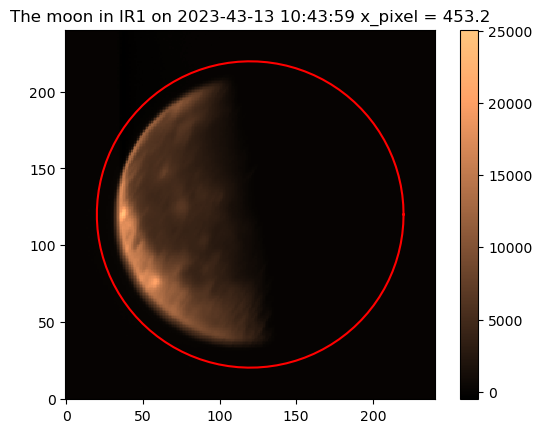

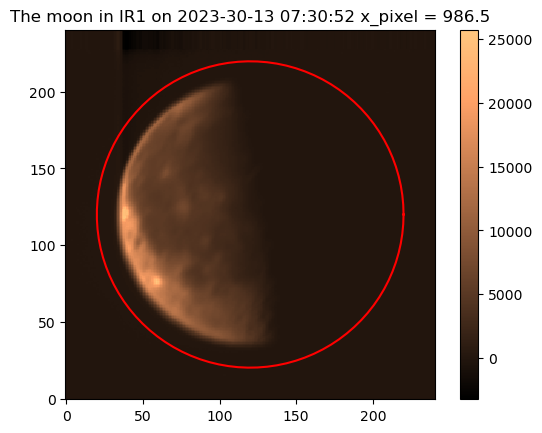

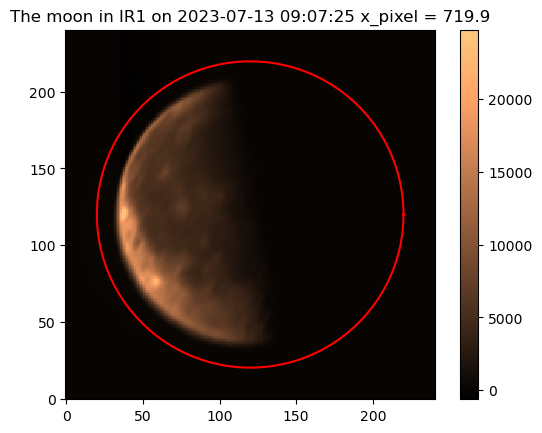

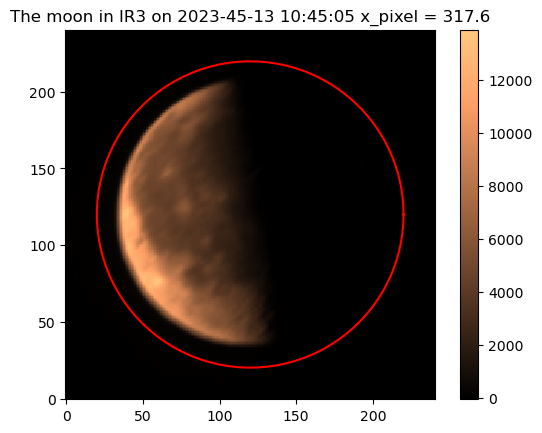

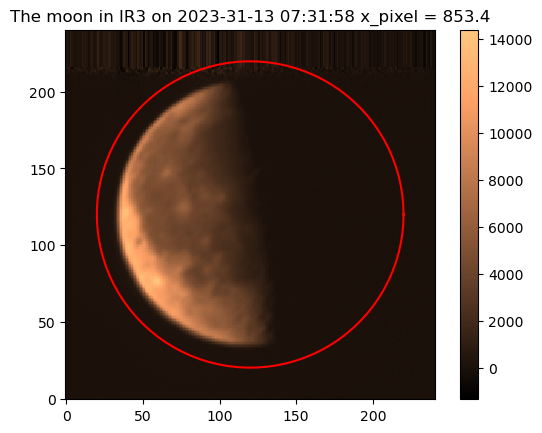

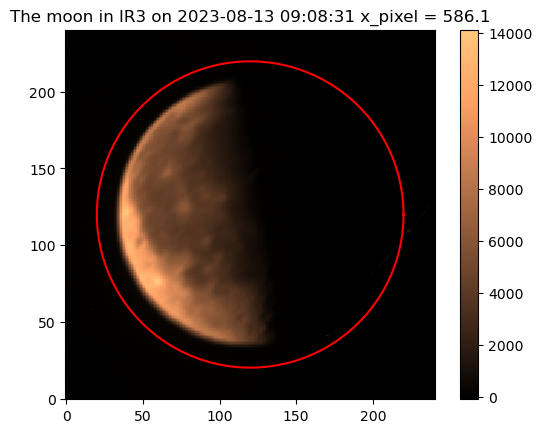

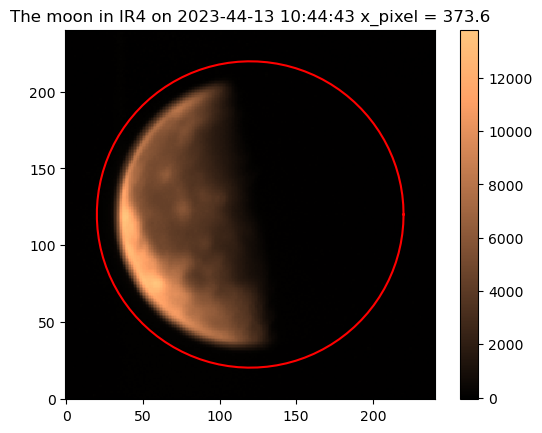

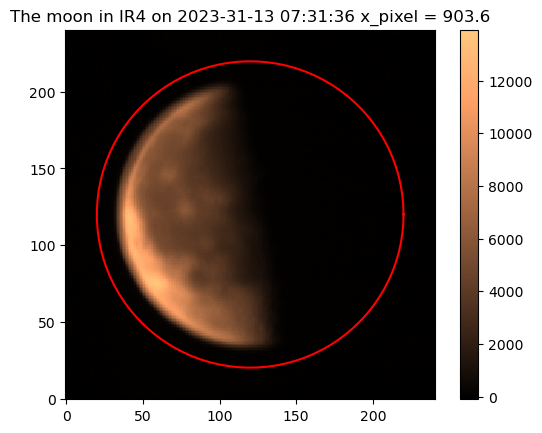

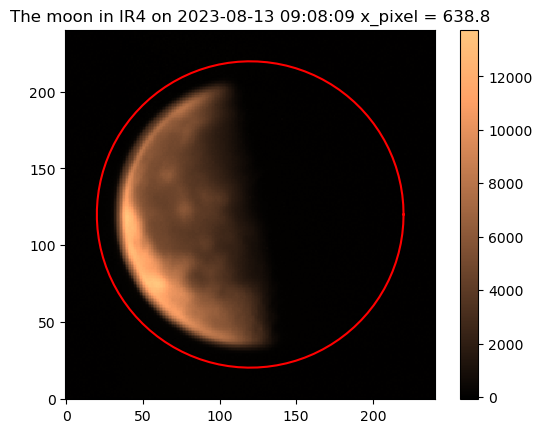

In [ ]:


cal='image_calib_nonflipped'
if cal=='l1a':
    channels=[ir1l1a, ir3l1a, ir4l1a]
    img='IMAGE'
    labelsuffix='_l1a'
elif cal=='l1b':
    channels=[ir1,ir3]
    img='ImageCalibrated'
    labelsuffix='_l1b'
elif cal=='cal':
    channels=[ir1l1a_cal,ir3l1a_cal, ir4l1a_cal]
    img='ImageCalibrated'
    labelsuffix='_cal'
elif cal=='image_lsb':
    channels=[ir1l1a_cal,ir3l1a_cal, ir4l1a_cal]
    img='image_lsb'
    labelsuffix='_image_lsb'
elif cal=='image_bias_sub':
    channels=[ir1l1a_cal,ir3l1a_cal, ir4l1a_cal]
    img='image_bias_sub'
    labelsuffix='_image_bias_sub'
elif cal=='image_desmeared':
    channels=[ir1l1a_cal,ir3l1a_cal, ir4l1a_cal]
    img='image_desmeared'
    labelsuffix='_image_desmeared'
elif cal=='image_dark_sub':
    channels=[ir1l1a_cal,ir3l1a_cal, ir4l1a_cal]
    img='image_dark_sub'
    labelsuffix='_image_dark_sub'
elif cal=='image_calib_nonflipped':
    channels=[ir1l1a_cal,ir3l1a_cal, ir4l1a_cal]
    img='image_calib_nonflipped'
    labelsuffix='_image_calib_nonflipped'


#image_lsb, image_bias_sub, image_desmeared, image_dark_sub, image_calib_nonflipped
autoname=[]
for ch in channels:
    oldlabel=ch['channel'].iloc[0]
    label=ch['channel'].iloc[0]+labelsuffix
    print(label)
    moons[label]=[]   
    autoname.append(label)
    for i in range(3): #go through the three images from the same channel
        print(ch.iloc[i].shape)
        res=resample_mooncal(ch.iloc[i],moons[oldlabel][i][1],moons[oldlabel][i][2],img, radius=100)
        moons[label].append(res)
        print(label)


Text(0, 0.5, 'sum of intensity')

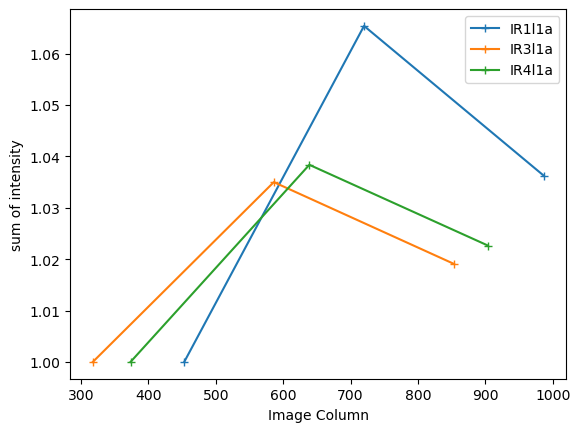

In [ ]:

box=120
radius=90#86.61805475083472
xs,ys=np.meshgrid(np.arange(2*box+1)-box,np.arange(2*box+1)-box,sparse=True)
filter=(xs**2+ys**2)<radius**2
plt.figure()
#names=['IR1_l1b','IR3_l1b']#,'IR4l1a_flatf','UV1l1a_flatf']
#names=['IR1_l1a','IR3_l1a']#,'IR4l1a_flatf','UV1l1a_flatf']
#names=['IR1_cal','IR3_cal','IR4_cal']#,'IR4l1a_flatf','UV1l1a_flatf']

for ch in autoname:
    
    sumref= [moons[ch][0][0][filter].sum() for i in range(3)]
    xval= [moons[ch][i][1] for i in (0,2,1)]
    sums= [moons[ch][i][0][filter].sum()/sumref[i] for i in range(3)]
    plt.plot(xval,sums,'-+')
plt.legend(names)
plt.xlabel('Image Column')
plt.ylabel('sum of intensity')